## 实战案例：Elo商户类别推荐

## 一、EDA (数据探索性分析：Data_Dictionary、merchant)

### 1. 导入数据集

In [159]:
# 导入库
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [160]:
# 查看竞赛提供的所有文件
os.listdir('../data/')

['Data Dictionary.xlsx',
 'Data_Dictionary.xlsx',
 'historical_transactions.csv',
 'merchants.csv',
 'new_merchant_transactions.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 '~$Data Dictionary.xlsx']

In [161]:
# 导入数据字典，和商户信息表
df = pd.read_excel(r'../data/Data_Dictionary.xlsx', sheet_name='merchant',skiprows=2)
merchant = pd.read_csv('../data/merchants.csv')

In [162]:
# 查看数据字典中的特征名含义
for v in df.values:
    print('Column: ',v[0],'Description: ',v[1])

Column:  merchant_id Description:  Unique merchant identifier
Column:  merchant_group_id Description:  Merchant group (anonymized )
Column:  merchant_category_id Description:  Unique identifier for merchant category (anonymized )
Column:  subsector_id Description:  Merchant category group (anonymized )
Column:  numerical_1 Description:  anonymized measure
Column:  numerical_2 Description:  anonymized measure
Column:  category_1 Description:  anonymized category
Column:  most_recent_sales_range Description:  Range of revenue (monetary units) in last active month --> A > B > C > D > E
Column:  most_recent_purchases_range Description:  Range of quantity of transactions in last active month --> A > B > C > D > E
Column:  avg_sales_lag3 Description:  Monthly average of revenue in last 3 months divided by revenue in last active month
Column:  avg_purchases_lag3 Description:  Monthly average of transactions in last 3 months divided by transactions in last active month
Column:  active_months_l

### 2. 数据准确性验证

In [163]:
# 首先检查商家信息数据的正确性
print(merchant.shape, merchant['merchant_id'].nunique())
print(pd.Series(merchant.columns.tolist()).sort_values().values ==  pd.Series([va[0] for va in df.values]).sort_values().values)

# 结论: 特征信息完全对上，且商家信息记录数据表不唯一，后续处理需要注意
merchant.head()

(334696, 22) 334633
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


### 3. 离散、连续数据探查和处理

In [164]:
# 根据商家信息表字段的离散和连续属性，参赛者可将两类字段分开后统一化分析，现字段分离如下
category_cols = ['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'category_4', 'city_id', 'state_id', 'category_2']
numeric_cols = ['numerical_1', 'numerical_2',
     'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12']
assert len(category_cols) + len(numeric_cols) == merchant.shape[1]

##### 3.1 离散数据object类型处理

In [165]:
merchant[category_cols].dtypes

merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
category_4                      object
city_id                          int64
state_id                         int64
category_2                     float64
dtype: object

In [166]:
merchant[category_cols].nunique()

merchant_id                    334633
merchant_group_id              109391
merchant_category_id              324
subsector_id                       41
category_1                          2
most_recent_sales_range             5
most_recent_purchases_range         5
category_4                          2
city_id                           271
state_id                           25
category_2                          5
dtype: int64

In [167]:
# 对object类型进行处理，处理成数字
# 统计里面的离散值的个数，按照个数，生成一个从0-n的list, 一一map上
def change_object_cols(se): 
    value = se.unique().tolist()
    value.sort()
    return se.map(pd.Series(range(len(value)), index=value)).values
for col in ['category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'category_4']:
    merchant[col] = change_object_cols(merchant[col])

merchant[category_cols].dtypes

merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
category_1                       int64
most_recent_sales_range          int64
most_recent_purchases_range      int64
category_4                       int64
city_id                          int64
state_id                         int64
category_2                     float64
dtype: object

##### 3.2 离散缺失值处理

In [168]:
# 看下缺失值
merchant.isnull().sum()

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

In [169]:
# 对缺失值以-1填充
merchant['category_2'] = merchant['category_2'].fillna(-1)


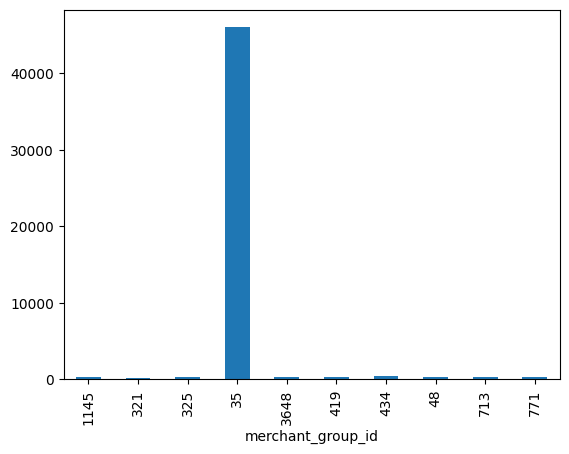

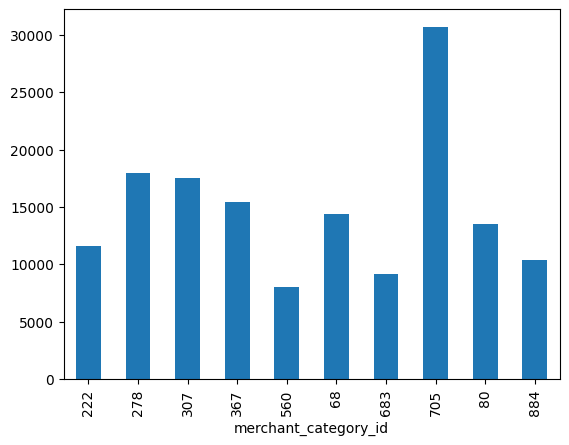

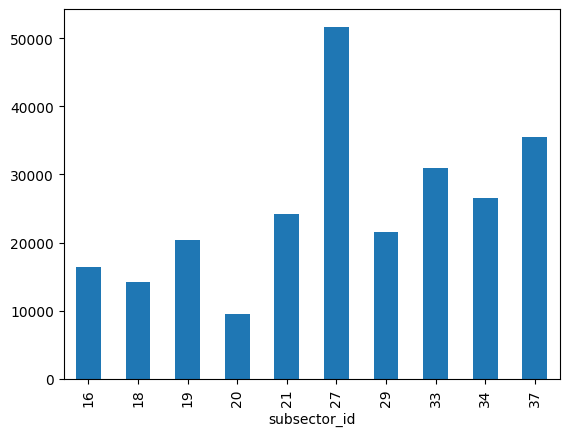

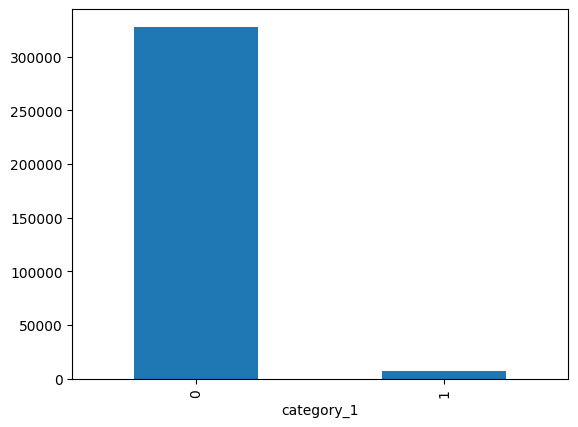

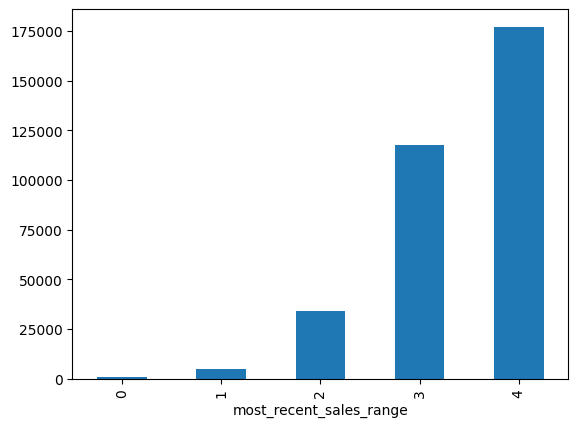

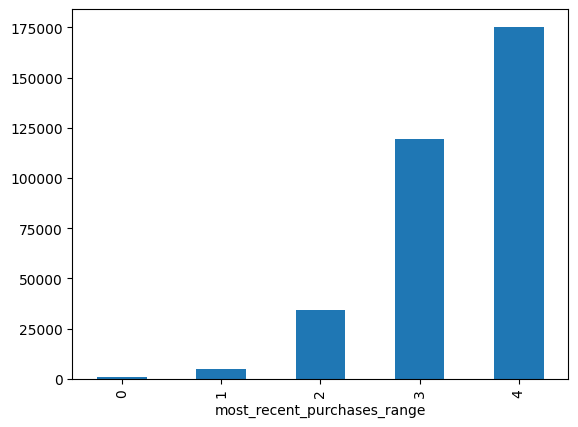

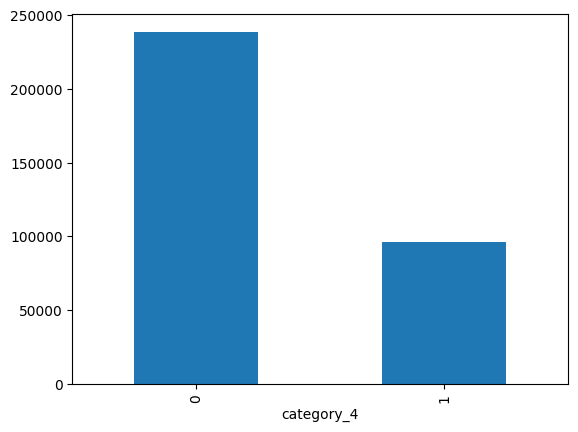

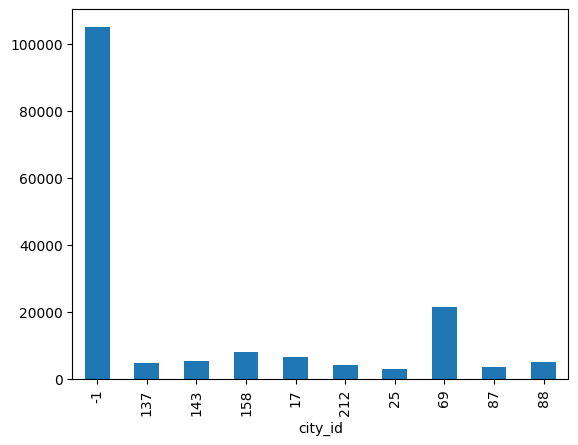

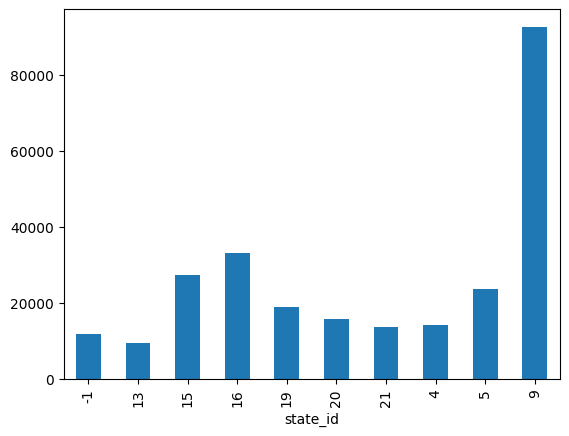

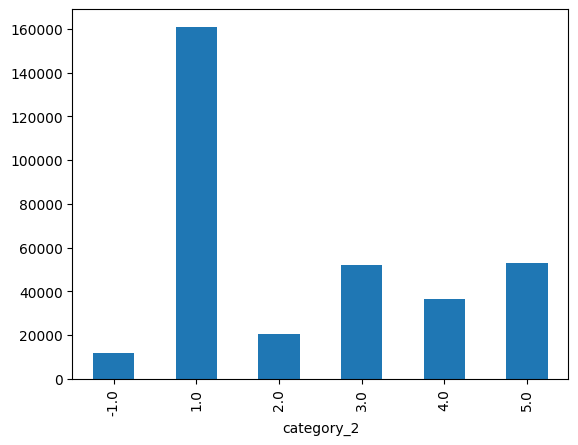

In [170]:
# 简单看下每个离散字段Top10的数量分布
for col in category_cols[1:]:
    merchant[col].astype(str).value_counts()[:10].sort_index().plot.bar()
    plt.show()
# 结论：在建模思路还不明确的情况下，参赛者可适当进行数据探查，也不必盲目面面俱到，做到心中有数
# 对数据结构有个清晰的了解，以便后续快速进行构思与方案验证

##### 3.3 连续数据的正无穷，缺失值处理

In [171]:
# 对连续型字段探查
merchant[numeric_cols].describe()

# 发现有正无穷值，这也是模型所不能接受的，因此需要对无限值进行处理

d:\ProgramData\miniconda3\envs\ml\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
d:\ProgramData\miniconda3\envs\ml\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
d:\ProgramData\miniconda3\envs\ml\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12
count,334696.000000,334696.000000,334683.000000,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000
mean,0.011476,0.008103,13.832993,inf,2.994108,2.165079e+01,inf,5.947397,2.522771e+01,inf,11.599335
std,1.098154,1.070497,2395.489999,NaN,0.095247,3.947108e+03,NaN,0.394936,5.251842e+03,NaN,1.520138
min,-0.057471,-0.057471,-82.130000,3.334953e-01,1.000000,-8.213000e+01,1.670447e-01,1.000000,-8.213000e+01,9.832954e-02,1.000000
25%,-0.057471,-0.057471,0.880000,9.236499e-01,3.000000,8.500000e-01,9.022475e-01,6.000000,8.500000e-01,8.983333e-01,12.000000
50%,-0.057471,-0.057471,1.000000,1.016667e+00,3.000000,1.010000e+00,1.026961e+00,6.000000,1.020000e+00,1.043361e+00,12.000000
75%,-0.047556,-0.047556,1.160000,1.146522e+00,3.000000,1.230000e+00,1.215575e+00,6.000000,1.290000e+00,1.266480e+00,12.000000
max,183.735111,182.079322,851844.640000,inf,3.000000,1.513959e+06,inf,6.000000,2.567408e+06,inf,12.000000


In [ ]:
# 先给inf替换成-99，之后查看当前数据集的最大值，以最大值再替换inf，想法很特别
inf_cols = ['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']
merchant[inf_cols] = merchant[inf_cols].replace(np.inf, merchant[inf_cols].replace(np.inf, -99).max().max())
merchant[numeric_cols].describe()

,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12
count,334696.000000,334696.000000,334683.000000,334696.000000,334696.000000,3.346830e+05,334696.000000,334696.000000,3.346830e+05,334696.000000,334696.000000
mean,0.011476,0.008103,13.832993,2.145143,2.994108,2.165079e+01,2.441947,5.947397,2.522771e+01,2.633572,11.599335
std,1.098154,1.070497,2395.489999,213.955844,0.095247,3.947108e+03,209.439373,0.394936,5.251842e+03,205.206198,1.520138
min,-0.057471,-0.057471,-82.130000,0.333495,1.000000,-8.213000e+01,0.167045,1.000000,-8.213000e+01,0.098330,1.000000
25%,-0.057471,-0.057471,0.880000,0.923650,3.000000,8.500000e-01,0.902247,6.000000,8.500000e-01,0.898333,12.000000
50%,-0.057471,-0.057471,1.000000,1.016667,3.000000,1.010000e+00,1.026961,6.000000,1.020000e+00,1.043361,12.000000
75%,-0.047556,-0.047556,1.160000,1.146522,3.000000,1.230000e+00,1.215575,6.000000,1.290000e+00,1.266480,12.000000
max,183.735111,182.079322,851844.640000,61851.333333,3.000000,1.513959e+06,61851.333333,6.000000,2.567408e+06,61851.333333,12.000000


In [173]:
# 对于离散字段的缺失值处理方式也有多样，这里先使用平均值进行填充，后续有需要再进行优化处理
for col in numeric_cols:
    merchant[col] = merchant[col].fillna(merchant[col].mean())

In [174]:
merchant[numeric_cols].describe()

,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,3.346960e+05,334696.000000,334696.000000,3.346960e+05,334696.000000,334696.000000
mean,0.011476,0.008103,13.832993,2.145143,2.994108,2.165079e+01,2.441947,5.947397,2.522771e+01,2.633572,11.599335
std,1.098154,1.070497,2395.443476,213.955844,0.095247,3.947031e+03,209.439373,0.394936,5.251740e+03,205.206198,1.520138
min,-0.057471,-0.057471,-82.130000,0.333495,1.000000,-8.213000e+01,0.167045,1.000000,-8.213000e+01,0.098330,1.000000
25%,-0.057471,-0.057471,0.880000,0.923650,3.000000,8.500000e-01,0.902247,6.000000,8.500000e-01,0.898333,12.000000
50%,-0.057471,-0.057471,1.000000,1.016667,3.000000,1.010000e+00,1.026961,6.000000,1.020000e+00,1.043361,12.000000
75%,-0.047556,-0.047556,1.160000,1.146522,3.000000,1.230000e+00,1.215575,6.000000,1.290000e+00,1.266480,12.000000
max,183.735111,182.079322,851844.640000,61851.333333,3.000000,1.513959e+06,61851.333333,6.000000,2.567408e+06,61851.333333,12.000000
